In [85]:
import json
from os import listdir
from os.path import join
import pandas as pd
import networkx as nx
from requests import get
import pycountry
from funcy import flatten

from typing import List

%matplotlib inline

# Collect data

This section collects .json files needed for analysis. 

Run this if you suspect the data has changed, or want to keep us honest.

Otherwise, skip to the next section.

In [2]:
urls = [
    'https://www.submarinecablemap.com/api/v3/cable/cable-geo.json',
    'https://www.submarinecablemap.com/api/v3/landing-point/landing-point-geo.json',
    'https://www.submarinecablemap.com/api/v3/search.json',
]

In [13]:
for url in urls:
    fn = url.split('/')[-1]
    print(fn)
#     resp = get(url).json() # comment out to prevent from bombarding the endpoint
    with open(join('json', fn), "w") as file:
        json.dump(resp, file)

cable-geo.json
landing-point-geo.json
search.json


In [56]:
with open(join('json', 'cable-geo.json'), 'r') as file:
    cables = json.load(file)

In [61]:
cable_ids = set([feature['properties']['id'] for feature in cables['features']])

In [ ]:
endpoint = 'https://www.submarinecablemap.com/api/v3/cable'
for cable in iter(cable_ids):
    print(cable)
    url = f"{endpoint}/{cable}.json"
#     resp = get(url).json() # comment out to prevent from bombarding the endpoint
    with open(join('json', 'cable', f'{cable}.json'), 'w') as file:
        json.dump(resp, file)

comoros-domestic-cable-system
scotland-northern-ireland-1
firmina
maldives-sri-lanka-cable-msc
denpasar-waingapu-cable-systems
greenland-connect-north
link-4-phase-2
gold-data-1
southeast-asia-japan-cable-sjc
isles-of-scilly-cable
estepona-tetouan
asia-connect-cable-1-acc-1
hantru1-cable-system
balalink
damai-cable-system
globalconnect-3-gc3
continente-madeira
oran-valencia-orval
juno
rockabill
okinawa-cellular-cable
scotland-northern-ireland-2
bay-of-bengal-gateway-bbg
saudi-arabia-sudan-1-sas-1
malta-italy-interconnector
apollo
ketchcan1-submarine-fiber-cable-system
eastern-caribbean-fiber-system-ecfs
gulf-of-mexico-fiber-optic-network
italy-croatia
kattegat-2
moratelindo-international-cable-system-1-mic-1
tonga-cable
timor-leste-south-submarine-cable-tlssc
boracay-palawan-submarine-cable-system-bpscs
manatua
uk-channel-islands-7
transcan-2
atisa
hronn
globalconnect-2-gc2
gtmo-1
pan-american-crossing-pac
nzadi-cable-system
energinet-laeso-varberg
jupiter
sat-3wasc
tokelau-submarine-c

the-east-african-marine-system-teams
dalian-yantai-cable
bt-north-sea
tui-samoa
sweden-latvia
confluence-1
sea-us
ionian
alba-1
go-1-mediterranean-cable-system
farice-1
indigo-west
taiwan-penghu-kinmen-matsu-no-2-tpkm2
java-bali-cable-system-jbcs
atlas-offshore
jakarta-surabaya-cable-system-jayabaya
eastern-light-sweden-finland-ii
trans-adriatic-express
fly-lion3
dos-continentes-l-ll
malbec
miyazaki-okinawa-cable-moc
au-aleutian
maroc-telecom-west-africa
grace-hopper
echo
sjjk
scandinavian-ring-south
yellow
bt-mt-1
energinet-lyngsa-laeso
hainan-to-hong-kong-express-h2he
fiber-optic-gulf-fog


# Create undersea cable graph

This section loads the JSON collected above to produce a graph (network) of undersea cables, in which cables are edges and nations are nodes.

In [3]:
def load_json_dir (directory: str) -> List[dict]: 
    '''
    Load each file in a directory of JSON files
    '''
    filenames = listdir(directory)
    def load_by_fn (fn: str) -> dict:
        return json.load(open(join(directory, fn)))
    lst = [load_by_fn(f) for f in filenames if f != 'search.json']
    return [l for l in lst if 'is_planned' in l] # some items aren't cables. use presence of `is_planned` key to determine whether item is a cable

In [6]:
cables = load_json_dir('json/cable/')

In [35]:
# get RFS years for historical analysis
rfs_years = pd.Series([cable['rfs_year'] for cable in cables]).sort_values().unique()
YEAR = 2023
rfs_years = rfs_years[rfs_years<=YEAR]
rfs_years

array([1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.])

In [36]:
def country_name_to_alpha2 (country_name):
    country = pycountry.countries.get(name=country_name)
    return country.alpha_2

In [37]:
def cc2_of (landing_point):
    country_name = landing_point['country']
    # cable geography uses non-ISO country names. this handles those cases
    cases = [
        ("Virgin Islands (U.K.)", 'GB'),
        ("Virgin Islands (U.S.)", 'US'),
        ("Sint Maarten", "NL"),
        ("Congo, Dem. Rep.", "CD"),
        ("Congo, Rep.", "CG"),
        ("Netherlands Antilles", "NL"),
        ("Russia", "RU"),
        ("Iran", "IR"),
        ("Brunei", "BN"),
        ("Vietnam", "VN"),
        ("Taiwan", "TW"),
        ("Venezuela", "VE"),
        ("Tanzania", "TZ"),
        ("Micronesia", "FM"),
        ("Syria", "SY"),
        ("South Korea", "KR"),
        ("Cape Verde", "CV"),
        ("Saint Martin", "MF"),
    ]
    # check specialc cases
    for name, cc2 in cases:
        if country_name == name:
            return cc2
    # if no matches, assume it's iso standard
    return country_name_to_alpha2(country_name)

# lp = cables[0]['landing_points'][0]
# cc2_of(lp)

In [71]:
from itertools import combinations

def add_to_edges_dict (a, b, edges_dict):
    # sort tuple
    # this assures there's one entry per pair of countries
    dict_key = tuple(sorted((a, b,), key=lambda tup: tup[0]))
    # side-effectily mutate edges_dict
    # TODO refactor to get rid of mutation
    if dict_key in edges_dict:
        edges_dict[dict_key] = edges_dict[dict_key]+1
    else:
        edges_dict[dict_key] = 1
        
def assemble_edges (max_rfs_year):
    '''
    Assemble edges for all cables where RFS year <= max_rfs_year.
    '''
    edges = {}
    for cable in cables:
        if cable['rfs_year'] and cable['rfs_year'] <= max_rfs_year:
            connections = [cc2_of(lp) for lp in cable['landing_points']]
            pairs = combinations(set(connections), 2)
            for pair in pairs:
                a, b = pair
                add_to_edges_dict(a, b, edges)
    return edges

assemble_edges(1990)

{('DK', 'SE'): 1, ('GB', 'IM'): 1}

In [49]:
# write_pickle('undersea_future_edges.pickle', assemble_edges())

## Cursory sense-check

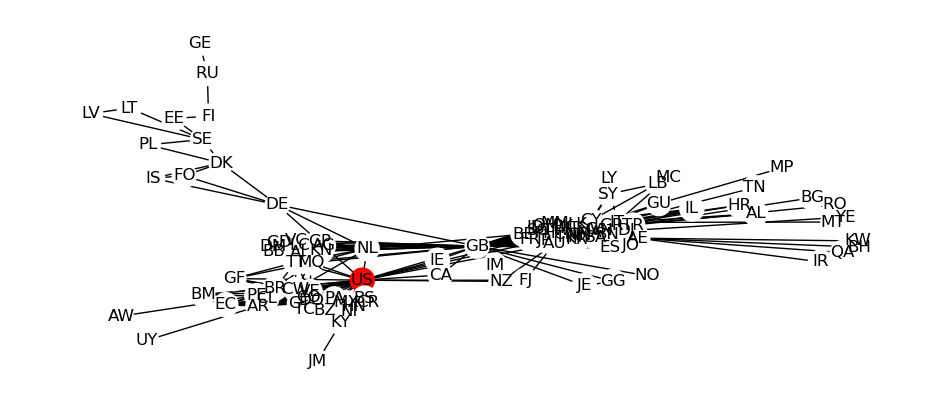

In [81]:
def construct_graph (max_rfs_year):
    G = nx.Graph()
    edges = assemble_edges(max_rfs_year)
    nodes = set(flatten(edges.keys()))
    for node in nodes:
        G.add_node(node)
    for edge, weight in edges.items():
        a, b = edge
        G.add_edge(a, b, weight=weight)
        
    return G

def plot_net (graph):
    color_map = []
    for node in graph:
        if node == 'US':
            color_map.append('red')
        else: 
            color_map.append('white')      
            
    fig, ax = plt.subplots(1, 1, figsize=(12, 5));
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()

plot_net(construct_graph(2001))

## Produce graphs for each RFS year in dataset, up til todasy

In [87]:
def write_pickle (fn, data):
    with open(fn, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
for year in rfs_years:
    year = int(year)
    print(year)
    G = construct_graph(year)
    nx.write_gpickle(G, join(f'graphs/{year}.pickle'))

1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
